In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Necessary Imports

In [2]:
import pandas as pd
import re
import numpy as np

#import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from sklearn.model_selection import TimeSeriesSplit

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Lambda, Input, Add
'''
%pip install scikeras
from scikeras.wrappers import KerasRegressor
'''
df_pkl = pd.read_pickle("/content/drive/MyDrive/Master_Thesis/Datasets/visuelle2/Extra_Datasets/dataFinal.pkl")
sales = pd.read_csv("/content/drive/MyDrive/Master_Thesis/Datasets/visuelle2/sales.csv")

In [3]:
df = df_pkl.sort_index()
display(df.head())

,Unnamed: 0,external_code,retail,season,category,color,image_path,fabric,release_date,restock,...,10,11,category_encoded,color_encoded,fabric_encoded,image_features,cat_gtrend,col_gtrend,fab_gtrend,date_encoded
0,0,5,36,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,22,...,0.0,0.0,11,4,0,2.499182,"[85.0, 84.0, 76.0, 65.0, 61.0, 59.0, 54.0, 53....","[20.0, 18.0, 18.0, 16.0, 18.0, 19.0, 17.0, 18....","[68.0, 69.0, 71.0, 78.0, 72.0, 69.0, 66.0, 69....",0
1,1,2,51,SS17,long sleeve,violet,PE17/00002.png,acrylic,2016-11-28,17,...,1.0,0.0,11,7,0,2.578126,"[85.0, 84.0, 76.0, 65.0, 61.0, 59.0, 54.0, 53....","[56.0, 58.0, 59.0, 54.0, 58.0, 55.0, 58.0, 59....","[68.0, 69.0, 71.0, 78.0, 72.0, 69.0, 66.0, 69....",0
2,2,5,10,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,15,...,0.0,1.0,11,4,0,2.499182,"[85.0, 84.0, 76.0, 65.0, 61.0, 59.0, 54.0, 53....","[20.0, 18.0, 18.0, 16.0, 18.0, 19.0, 17.0, 18....","[68.0, 69.0, 71.0, 78.0, 72.0, 69.0, 66.0, 69....",0
3,3,9,41,SS17,culottes,yellow,PE17/00009.png,scuba crepe,2016-11-28,32,...,0.0,0.0,1,9,49,1.695715,"[46.0, 52.0, 48.0, 47.0, 47.0, 48.0, 35.0, 56....","[72.0, 73.0, 71.0, 74.0, 74.0, 74.0, 75.0, 77....","[0.0, 17.0, 18.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0....",0
4,4,5,13,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,26,...,0.0,0.0,11,4,0,2.499182,"[85.0, 84.0, 76.0, 65.0, 61.0, 59.0, 54.0, 53....","[20.0, 18.0, 18.0, 16.0, 18.0, 19.0, 17.0, 18....","[68.0, 69.0, 71.0, 78.0, 72.0, 69.0, 66.0, 69....",0


# Features Handling

In [4]:
cols = ['cat_gtrend', 'col_gtrend', 'fab_gtrend']

for col in cols:
    df[col] = df[col].apply(np.mean) # reducing dimension by taking mean

#replace NaN with zeros
df.fillna(0, inplace=True)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


# Split Data

In [5]:
#split data
x_train = df[['category_encoded', 'fabric_encoded', 'color_encoded', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9','image_features', 'cat_gtrend', 'col_gtrend', 'fab_gtrend','date_encoded']]

y_train = df[['10']]

x_test = df[['category_encoded', 'fabric_encoded', 'color_encoded', '1', '2', '3', '4', '5', '6', '7', '8', '9','10','image_features', 'cat_gtrend', 'col_gtrend', 'fab_gtrend','date_encoded']]

y_test = df[['11']]


x_test_original = x_test.to_numpy()  # saving it for plotting

# Select TimeSeries columns
scale_columns_train = ['category_encoded', 'fabric_encoded', 'color_encoded', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9','image_features', 'cat_gtrend', 'col_gtrend', 'fab_gtrend']
scale_columns_test = ['category_encoded', 'fabric_encoded', 'color_encoded', '1', '2', '3', '4', '5', '6', '7', '8', '9','10','image_features', 'cat_gtrend', 'col_gtrend', 'fab_gtrend']

# Convert specific DataFrame columns to a NumPy array
x_train_np = x_train.loc[:,scale_columns_train].to_numpy()
x_test_np = x_test.loc[:,scale_columns_test].to_numpy()


# Standardize the NumPy array
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_np)
x_test_scaled = scaler.transform(x_test_np)

# Replace original DataFrame columns with standardized values
x_train.loc[:,scale_columns_train] = x_train_scaled
x_test.loc[:,scale_columns_test] = x_test_scaled

# Convert entire DataFrame to a NumPy array
x_train = x_train.values
y_train = y_train.values
x_test = x_test.values
y_test = y_test.values

# Model Creation

# Create Model

##Generic nbeats

In [6]:
from keras.layers import Input, Dense, Lambda, Subtract, Add
from keras.models import Model
from keras import initializers

# Define the number of input features, output features, hidden units, and blocks
input_dim = 18
output_dim = 1
hidden_dim = 64
k = 2  # number of blocks in each stack
m = 3  # number of stacks

def NBEATSBlock(input_layer, hidden_dim):
    x = input_layer
    for _ in range(4):  # each block has 4 Dense layers with ReLU activation
        x = Dense(hidden_dim, activation='relu')(x)
    # each block has 2 linear layers for backcast and forecast
    expansion_coefficient = Dense(1, activation='linear', kernel_initializer=initializers.RandomNormal(stddev=0.01))(x)  # learnable parameter for basis expansion
    backcast = Dense(input_dim, activation='linear')(x * expansion_coefficient)  # backcast
    forecast = Dense(output_dim, activation='linear')(x * expansion_coefficient)  # forecast
    return backcast, forecast

# Define the N-BEATS stack
def NBEATSStack(input_layer, hidden_dim, k):
    backcast = input_layer
    forecasts = []
    for _ in range(k):  # create k blocks in the stack
        backcast, forecast = NBEATSBlock(backcast, hidden_dim)
        backcast = Subtract()([input_layer, backcast])
        input_layer = backcast
        forecasts.append(forecast)
    forecast = Add()(forecasts)
    return backcast, forecast

# Create an input layer
input_layer = Input(shape=(input_dim,))

# Create the backcast and forecast from each stack
stack_input = input_layer
global_forecasts = []
for _ in range(m):  # create m stacks
    stack_input, stack_forecast = NBEATSStack(stack_input, hidden_dim, k)
    global_forecasts.append(stack_forecast)

global_forecast = Add()(global_forecasts)

# Create the model
model = Model(inputs=input_layer, outputs=global_forecast)
model.compile(optimizer='adam', loss='mse')
#model.summary()

In [ ]:
#@title NBeats Class
class NBEATSModel:
    def __init__(self, input_dim, output_dim, hidden_dim, k, m):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.k = k
        self.m = m
        self.model = self.build_model()

    def NBEATSBlock(self, input_layer):
        x = input_layer
        for _ in range(4):  # each block has 4 Dense layers with ReLU activation
            x = Dense(self.hidden_dim, activation='relu')(x)
        # each block has 2 linear layers for backcast and forecast
        backcast = Dense(input_dim, activation='linear')(x)  # backcast
        forecast = Dense(output_dim, activation='linear')(x)  # forecast
        return backcast, forecast

    def NBEATSStack(self, input_layer):
        backcast = input_layer
        forecasts = []
        for _ in range(self.k):  # create k blocks in the stack
            backcast, forecast = self.NBEATSBlock(backcast)
            backcast = Subtract()([input_layer, backcast])
            forecasts.append(forecast)
        forecast = Add()(forecasts)
        return backcast, forecast

    def build_model(self):
        input_layer = Input(shape=(self.input_dim,))
        stack_input = input_layer
        global_forecasts = []
        for _ in range(self.m):  # create m stacks
            stack_input, stack_forecast = self.NBEATSStack(stack_input)
            global_forecasts.append(stack_forecast)
        global_forecast = Add()(global_forecasts)
        model = Model(inputs=input_layer, outputs=global_forecast)
        model.compile(optimizer='adam', loss='mse')
        return model


#Plot Model

In [ ]:
model.summary()

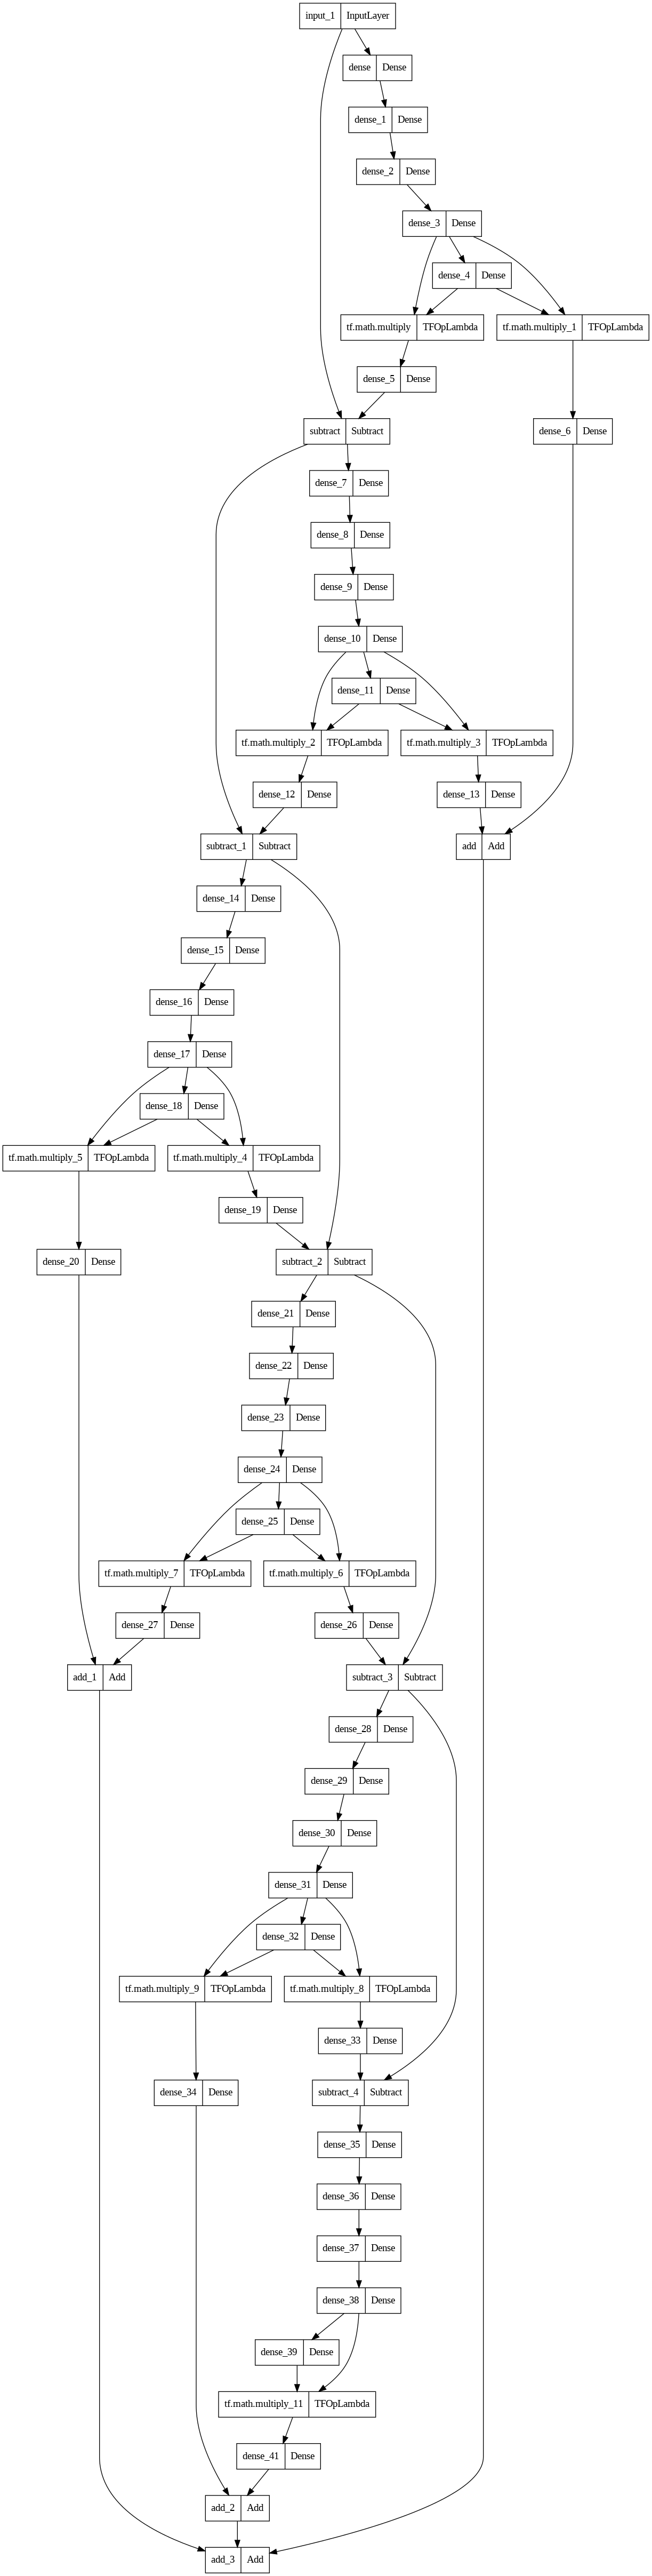

In [7]:
tf.keras.utils.plot_model(model)

# Load tensorBoard


In [8]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard
from datetime import datetime
import tensorboard
from tensorflow import keras
tensorboard.__version__

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Model Fitting

In [9]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                    batch_size=34, verbose=2, epochs=6, callbacks=[tensorboard_callback])

Epoch 1/6
3143/3143 - 42s - loss: 2.0123 - val_loss: 1.6111 - 42s/epoch - 13ms/step
Epoch 2/6
3143/3143 - 30s - loss: 1.7985 - val_loss: 1.4902 - 30s/epoch - 10ms/step
Epoch 3/6
3143/3143 - 31s - loss: 2.1571 - val_loss: 1.5563 - 31s/epoch - 10ms/step
Epoch 4/6
3143/3143 - 32s - loss: 1.7426 - val_loss: 1.4650 - 32s/epoch - 10ms/step
Epoch 5/6
3143/3143 - 32s - loss: 1.7362 - val_loss: 1.4487 - 32s/epoch - 10ms/step
Epoch 6/6
3143/3143 - 30s - loss: 1.8968 - val_loss: 1.4414 - 30s/epoch - 10ms/step


# Plot Loss

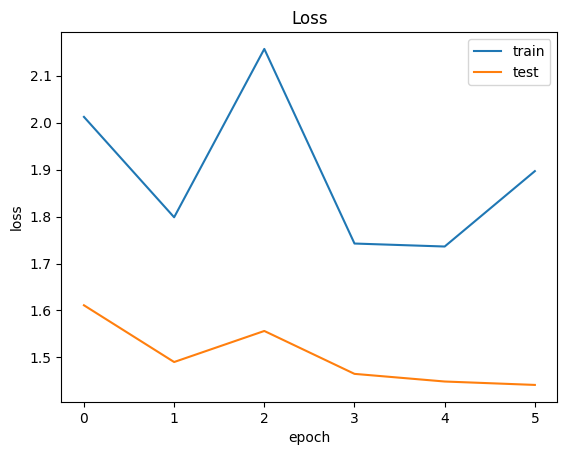

In [10]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train','test'], loc = 'upper right')
plt.show()


# Final Evaluation

In [11]:
# Make predictions on the training and validation data.
y_train_pred =model.predict(x_train)
y_test_pred = model.predict(x_test)

# Calculate and print the Root Mean Squared Error (RMSE) for training and validation predictions.
print("Training MSE: ", (mse(y_train, y_train_pred)))
print("Validation MSE: ", (mse(y_test, y_test_pred)))

3340/3340 [==============================] - 10s 3ms/step
Training MSE:  1.6183680149849182
Validation MSE:  1.4414054834254877


In [12]:
#Weighted Absolute Percent Error
model_wape = ((mae(y_test,y_test_pred)*int(len(y_test_pred)) ) / sum(y_test)[0])*100
print("Model Validation wape : ", model_wape)

wape_values = []
wape_values.append({"model": model_wape})

mae_values = []
model_mae = mae(y_test, y_test_pred)
mae_values.append({"model_mae": model_mae})
print("Model Validation mae : ", model_mae)

Model Validation wape :  111.11894078364206
Model Validation mae :  0.7209159768838217


## **Plot Predictions**

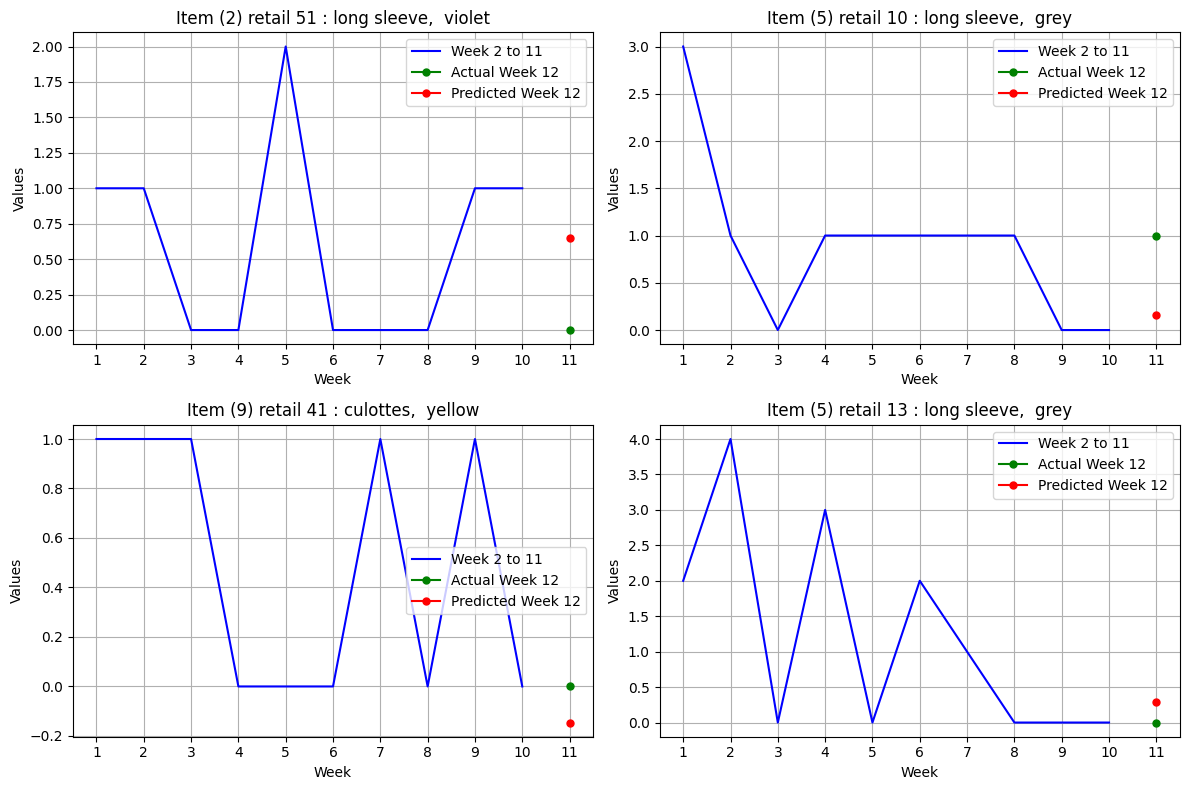

In [13]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, ax in enumerate(axs.flat, start=1):
    # Plot original data from week 1 to 11 in blue
    ax.plot(range(1, 11), x_test_original[i, 3:13], color='blue', label='Week 2 to 11')

    # Plot actual data for week 12 in green
    ax.plot(11, y_test[i], marker='o', markersize=5, color='green', label='Actual Week 12')

    # Plot predicted data for week 12 in red
    ax.plot(11, y_test_pred[i], marker='o', markersize=5, color='red', label='Predicted Week 12')

    ax.set_xticks(range(1, 12))  # Set the x-axis ticks from 1 to 12
    ax.set_xlabel('Week')
    ax.set_ylabel('Values')
    ax.set_title(f'Item ({sales.external_code[i]}) retail {sales.retail[i]} : {sales.category[i]},  {sales.color[i]}')
    ax.legend()
    # Add a grid to the subplot
    ax.grid(True)

plt.tight_layout()
plt.show()

# Cross Validations

# Model Redefinition

In [ ]:
from keras.layers import Input, Dense, Lambda, Subtract, Add
from keras.models import Model

# Define the number of input features, output features, hidden units, and blocks
input_dim = 18
output_dim = 1
hidden_dim = 64
k = 3  # number of blocks in each stack
m = 2  # number of stacks

# Define the N-BEATS block
def NBEATSBlock(input_layer, hidden_dim):
    x = input_layer
    for _ in range(4):  # each block has 4 Dense layers with ReLU activation
        x = Dense(hidden_dim, activation='relu')(x)
    # each block has 2 linear layers for backcast and forecast
    expansion_coefficient = Dense(1, activation='linear', kernel_initializer=initializers.RandomNormal(stddev=0.01))(x)  # learnable parameter for basis expansion
    backcast = Dense(input_dim, activation='linear')(x * expansion_coefficient)  # backcast
    forecast = Dense(output_dim, activation='linear')(x * expansion_coefficient)  # forecast
    return backcast, forecast

# Define the N-BEATS stack
def NBEATSStack(input_layer, hidden_dim, k):
    backcast = input_layer
    forecasts = []
    for _ in range(k):  # create k blocks in the stack
        backcast, forecast = NBEATSBlock(backcast, hidden_dim)
        backcast = Subtract()([input_layer, backcast])
        forecasts.append(forecast)
    forecast = Add()(forecasts)
    return backcast, forecast

# Create an input layer
input_layer = Input(shape=(input_dim,))

# Create the backcast and forecast from each stack
stack_input = input_layer
global_forecasts = []
for _ in range(m):  # create m stacks
    stack_input, stack_forecast = NBEATSStack(stack_input, hidden_dim, k)
    global_forecasts.append(stack_forecast)

global_forecast = Add()(global_forecasts)

# Create the model
createModel = Model(inputs=input_layer, outputs=global_forecast)
createModel.compile(optimizer='adam', loss='mse')
#createModel.summary()

# TimeSeriesSplit AKA Walk Forward

In [ ]:
# Specify the number of folds for cross-validation
n_splits = 5

tscv = TimeSeriesSplit(n_splits=5)

mae_tscv = []
wape_tscv = []

# Create and compile the Keras model
model = createModel
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Initialize a list to store cross-validation scores
cv_scores = []


# Perform cross-validation
for train_index, test_index in tscv.split(x_train):
    x_train_temp, x_test_temp = x_train[train_index], x_train[test_index]
    y_train_temp, y_test_temp = y_train[train_index], y_train[test_index]

    # Train the model on the training data
    model.fit(x_train_temp, y_train_temp,validation_data=(x_test_temp, y_test_temp), epochs=5, batch_size=16)

    # Evaluate the model on the test data
    y_pred = model.predict(x_test_temp)

    # Calculate Weighted Mean Absolute Percent Error for this fold
    wf_wape = ((mae(y_test_temp, y_pred)*len(y_pred)) / sum(y_test_temp)[0])*100
    #print("Fold WAPE: ", wf_wape)
    wape_tscv.append(wf_wape)

    # Calculate Mean Absolute Error for this fold
    wf_mae = mae(y_test_temp, y_pred)
    #print("Fold MAE: ", wf_mae)
    mae_tscv.append(wf_mae)

WAPE = sum(wape_tscv) / len(wape_tscv)
wape_values.append({"Walk forward CV": WAPE})

MAE = sum(mae_tscv) / len(mae_tscv)
mae_values.append({"Walk forward CV": MAE})

# Calculate and print mean WAPE and MAE across all folds
print('\n\n************ TimeseriesSplit/WalkForward Cross Validation ***************\n')
print("Mean WAPE : ", WAPE)
print("Mean MAE : ",  MAE)

Epoch 1/5
1114/1114 [==============================] - 20s 11ms/step - loss: 1.7689 - mse: 1.7689 - val_loss: 2.3806 - val_mse: 2.3806
Epoch 2/5
1114/1114 [==============================] - 13s 12ms/step - loss: 1.6651 - mse: 1.6651 - val_loss: 2.2163 - val_mse: 2.2163
Epoch 3/5
1114/1114 [==============================] - 13s 12ms/step - loss: 1.6545 - mse: 1.6545 - val_loss: 2.2774 - val_mse: 2.2774
Epoch 4/5
1114/1114 [==============================] - 13s 12ms/step - loss: 1.5665 - mse: 1.5665 - val_loss: 1.8796 - val_mse: 1.8796
Epoch 5/5
557/557 [==============================] - 2s 2ms/step
Epoch 1/5
2227/2227 [==============================] - 20s 9ms/step - loss: 24.8724 - mse: 24.8724 - val_loss: 2.2399 - val_mse: 2.2399
Epoch 2/5
2227/2227 [==============================] - 19s 8ms/step - loss: 1.5430 - mse: 1.5430 - val_loss: 2.0462 - val_mse: 2.0462
Epoch 3/5
2227/2227 [==============================] - 19s 9ms/step - loss: 1.5008 - mse: 1.5008 - val_loss: 2.0724 - val_mse

# Grouped time_series CV



In [ ]:
def group_time_series_cv(model, X, y, groups, n_splits=2):

    unique_groups = np.unique(groups)
    splits = np.array_split(unique_groups, n_splits+1)
    mse_gcv = []
    mae_gcv = []
    wape_gcv = []

    for i in range(len(splits)-1):
        train_groups = np.concatenate(splits[0:i+1])
        test_groups = splits[i+1]

        train_index = np.isin(groups, train_groups)
        test_index = np.isin(groups, test_groups)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Print unique values of X[:,12] for each split
        #print("Unique values in train split:", np.unique(X_train[:,-1]))
        #print("Unique values in test split:", np.unique(X_test[:,-1]))

        # Train the model on the training data
        model.fit(X_train, y_train, validation_data=(X_test, y_test),  epochs=5, batch_size=16)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Evaluate performance
        gts_mse = mse(y_test, y_pred)
        mse_gcv.append(gts_mse)

        #Weighted Absolute Percent Error
        gts_wape = ((mae(y_test,y_pred)*int(len(y_pred)) ) / sum(y_test)[0])*100
        wape_gcv.append(gts_wape)
        #print(f"fold {i} gts_wape:",gts_wape)

        gts_mae = mae(y_test, y_pred)
        mae_gcv.append(gts_mae)
        #print(f"fold {i} gts_mae:", gts_mae)

    mse_gcv = np.array(mse_gcv)
    return mse_gcv, model, wape_gcv, mae_gcv

model_gcv = createModel
model_gcv.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

groups = x_train[:,-1] #choose Last column(encoded release date)
#print('group_size:',groups.shape)


mse_gcv, model, wape_gcv, mae_gcv = group_time_series_cv(model_gcv, x_train, y_train, groups, n_splits=5)

WAPE = sum(wape_gcv) / len(wape_gcv)
wape_values.append({"Group CV": WAPE})

MAE = sum(mae_gcv)/len(mae_gcv)
mae_values.append({"Group CV": MAE})

print('\n\n************ Group Timeseries Cross Validation ***************\n')
print("Mean Squared Error:", mse_gcv.mean())
print("Mean WAPE", WAPE)
print("Mean MAE:", MAE)


Epoch 1/5
725/725 [==============================] - 16s 13ms/step - loss: 1.5957 - mse: 1.5957 - val_loss: 1.5810 - val_mse: 1.5810
Epoch 2/5
725/725 [==============================] - 7s 10ms/step - loss: 1.5695 - mse: 1.5695 - val_loss: 1.6744 - val_mse: 1.6744
Epoch 3/5
725/725 [==============================] - 9s 12ms/step - loss: 1.4536 - mse: 1.4536 - val_loss: 1.6822 - val_mse: 1.6822
Epoch 4/5
725/725 [==============================] - 10s 14ms/step - loss: 1.4102 - mse: 1.4102 - val_loss: 1.6396 - val_mse: 1.6396
Epoch 5/5
516/516 [==============================] - 2s 3ms/step
Epoch 1/5
1756/1756 [==============================] - 16s 9ms/step - loss: 1.4832 - mse: 1.4832 - val_loss: 2.0650 - val_mse: 2.0650
Epoch 2/5
1756/1756 [==============================] - 16s 9ms/step - loss: 1.4336 - mse: 1.4336 - val_loss: 2.1942 - val_mse: 2.1942
Epoch 3/5
1756/1756 [==============================] - 16s 9ms/step - loss: 1.4898 - mse: 1.4898 - val_loss: 2.1225 - val_mse: 2.1225
Epo

ValueError: Input contains NaN.

# Purged Grouped Time_series CV


In [ ]:
def purged_group_time_series_cv_iterative(X, y, groups, n_splits = 5, group_gap = 1 ):

    model = createModel
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

    mse_scores = []
    mae_pgcv = []
    wape_pgcv = []


    unique_groups = np.unique(groups)
    splits = np.array_split(unique_groups, n_splits+1)


    for i in range(len(splits)-1):
        train_groups = splits[i].ravel()
        #print('train:',train_groups)
        test_groups = splits[i+1].ravel()
        #print('test:',test_groups)

        train_groups = train_groups[:-group_gap]
        test_groups = test_groups[group_gap:]

        train_index = np.isin(groups, train_groups)
        test_index = np.isin(groups, test_groups)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Print unique values of X[:,12] for each split
        #print("Unique values in train split:", np.unique(X_train[:,-1]))
        #print("Unique values in test split:", np.unique(X_test[:,-1]))

        # Train the model
        model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size = 16)

        # Make predictions on the validation set
        y_pred = model.predict(X_test)

        # Evaluate performance
        mse_pgcv = mse(y_test, y_pred)

        mse_scores.append(mse_pgcv)

        mae_fold = mae(y_test, y_pred)
        mae_pgcv.append(mae_fold)
        #print(f"fold {i} pgcv_mae:", mae_pgcv)

        #Weighted Absolute Percent Error
        wape_fold = ((mae(y_test,y_pred)*int(len(y_pred)) ) / sum(y_test)[0])*100
        wape_pgcv.append(wape_fold)
        #print(f"fold {i} pgcv_wape:",wape_fold)


    mse_scores = np.array(mse_scores)
    return mse_scores, model, mae_pgcv, wape_pgcv

groups = x_train[:,-1]

# Set the number of splits for cross-validation
n_splits = 5

# Set the group gap
group_gap = 1

# Perform Iterative Purged Group Time Series Cross-Validation
mse_scores, model, mae_pgcv, wape_pgcv = purged_group_time_series_cv_iterative(x_train, y_train, groups, n_splits=n_splits, group_gap=group_gap)

WAPE = sum(wape_pgcv) / len(wape_pgcv)
wape_values.append({"Purged Group CV": WAPE})

MAE = sum(mae_pgcv)/len(mae_pgcv)
mae_values.append({"Purged Group CV": MAE})

print('\n\n************ Purged Group Cross Validation ***************\n')
print("Mean Squared Error", mse_scores.mean())
print("Mean WAPE", WAPE)
print("Mean MAE:", MAE)

# Combinatorial Purged Group Cross Validation

In [ ]:
def purge_and_embargo(arr,start = 0, end =  161):
  arr = np.sort(arr)
  indices = np.where(np.diff(arr) != 1)[0]
  new_arr = np.delete(arr, np.concatenate([indices, indices+1]))
  if new_arr[0] != start:
    new_arr = np.delete(new_arr, 0)
  if new_arr[-1] != end:
    new_arr = np.delete(new_arr, -1)
  return new_arr

In [ ]:
def combinatorial_group_time_series_cv(model, X, y, groups, n_splits=6, test_set = 2):
    unique_groups = np.unique(groups)
    splits = np.array_split(unique_groups, n_splits)
    mse_scores = []
    mae_cpcv = []
    wape_cpcv = []

    test_splits = list(combinations(splits, 2))

    for i, test_groups in enumerate(test_splits):
        train_groups = [split for split in splits if all(split is not t for t in test_groups)]
        #train_test.append([train, list(test)])

        test_groups = np.concatenate(test_groups)
        train_groups = np.concatenate(train_groups)


        train_groups = purge_and_embargo(train_groups)
        test_groups = purge_and_embargo(test_groups)

        train_index = np.isin(groups, train_groups)
        test_index = np.isin(groups, test_groups)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Print unique values of X[:,12] for each split
        #print("Unique values in train split:", np.unique(X_train[:,-1]))
        #print("Unique values in test split:", np.unique(X_test[:,-1]))

        # Train the model
        model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=5, batch_size = 16)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Evaluate performance
        mse_cpcv = mse(y_test, y_pred)
        mse_scores.append(mse_cpcv)

        #Weighted Absolute Percent Error
        wape_fold = ((mae(y_test,y_pred)*int(len(y_pred)) ) / sum(y_test)[0])*100
        wape_cpcv.append(wape_fold)
        #print(f"split {i} cpcv_wape:",cpcv_wape)


        mae_fold = mae(y_test, y_pred)
        mae_cpcv.append(mae_fold)
        #print(f"split {i} cpcv_mae:", cpcv_mae)

    mse_scores = np.array(mse_scores)
    return mse_scores, model, wape_cpcv, mae_cpcv

groups = x_train[:,-1] #choose Last column(encoded release date)
#print('group_size:',groups.shape)

# Initialize the model
model_cpcv = createModel
model_cpcv.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

mse_scores, model, wape_cpcv, mae_cpcv = combinatorial_group_time_series_cv(model_cpcv, x_train, y_train, groups, n_splits=6, test_set=2)

WAPE = sum(wape_cpcv) / len(wape_cpcv)
wape_values.append({"Combinatorial Purged Group CV": WAPE})

MAE = sum(mae_cpcv)/len(mae_cpcv)
mae_values.append({"Combinatorial Purged Group CV": MAE})

print('\n\n************ Combinatorial Purged Group Cross Validation ***************\n')
print("Mean Squared Error:", mse_scores.mean())
print("Mean WAPE", WAPE)
print("Mean MAE", MAE)

## **WAPE Results**

In [ ]:
models = [list(item.keys())[0] for item in wape_values]
values = [list(item.values())[0] for item in wape_values]

# Create the bar plot
plt.figure(figsize=(15, 8))

plt.bar(models, values)
plt.xlabel('Models')
plt.ylabel('WAPE Values')
plt.title('Bar plot of WAPE Values for Different Models')
plt.show()

## **MAE Results**

In [ ]:
models = [list(item.keys())[0] for item in mae_values]
values = [list(item.values())[0] for item in mae_values]

# Create the bar plot
plt.figure(figsize=(15, 8))

plt.bar(models, values)
plt.xlabel('Models')
plt.ylabel('MAE Values')
plt.title('Bar plot of MAE Values for Different Models')
plt.show()

In [ ]:
print("WAPE")
display(wape_values)

print("\n\n=============================\n\n")

print("MAE")
display(mae_values)

# trying the model with m5 just for fun

In [ ]:
#@title Data Loading
def process_file(file_name, base_path, optimize=False, store=False, pickle = False):
    try:
        if pickle == False:
          print(f"Reading {file_name}...")
          df = pd.read_csv(base_path + file_name)
          print(f"File Size: {round(df.memory_usage(deep=True).sum() / 1024 ** 2, 2)} MB")

        if optimize:
            print(f"Optimizing {file_name}...")
            df = reduce_memory(df, verbose=True)
            print(f"Size after optimization: {round(df.memory_usage(deep=True).sum() / 1024 ** 2, 2)} MB\n")

        if store:
            df.to_pickle(base_path + file_name.split('.')[0] + '.pkl')
            print(f"Pickle file is stored as {file_name.split('.')[0]}.pkl")

        if pickle:
            print(f"Reading {file_name.split('.')[0]}.pkl...")
            df = pd.read_pickle(base_path + file_name.split('.')[0] + '.pkl')
            print(f"File Size: {round(df.memory_usage(deep=True).sum() / 1024 ** 2, 2)} MB")
    except Exception as e:
        print(f"Error: {e}")
    return df

# Usage
base_path = "/content/drive/MyDrive/Master_Thesis/Datasets/M5-Forecasting-accuracy/"
#base_path = "C:/Users/abcr5914/Downloads/M5-Forecasting-accuracy/"

sell_price_df = process_file("sell_prices.csv", base_path, optimize=False, store=False)
calendar_df = process_file("calendar.csv", base_path)
#sales_train_evaluation_df = process_file("sales_train_evaluation.csv", base_path, optimize=True, store=True)
sales_train_evaluation_df = process_file("sales_train_evaluation.csv", base_path, pickle = True)

Reading sell_prices.csv...
File Size: 957.52 MB
Reading calendar.csv...
File Size: 0.72 MB
Reading sales_train_evaluation.pkl...
File Size: 105.99 MB


In [ ]:
dates_df = calendar_df[['date','d','wm_yr_wk']].set_index('wm_yr_wk',drop =True)

In [ ]:
calendar_df.drop(columns =['event_type_1','event_type_2','month','year','weekday','d'],inplace = True)

In [ ]:
! pip install --upgrade category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 818.3 kB/s eta 0:00:00


In [ ]:
import category_encoders as ce

# Combine the event columns into a new column
calendar_df['combined_events'] = calendar_df['event_name_1'].astype(str) + "_" + \
                                 calendar_df['event_type_1'].astype(str) + "_" + \
                                 calendar_df['event_name_2'].astype(str) + "_" + \
                                 calendar_df['event_type_2'].astype(str)

# Create a binary encoder
binary_enc = ce.BinaryEncoder(cols=['combined_events'])

# Fit and transform the data
calendar_df_binary = binary_enc.fit_transform(calendar_df)

calendar_df_binary.head()


,date,wm_yr_wk,wday,snap_CA,snap_TX,snap_WI,combined_events_0,combined_events_1,combined_events_2,combined_events_3,combined_events_4,combined_events_5
0,2011-01-29,11101,1,0,0,0,0,0,0,0,0,1
1,2011-01-30,11101,2,0,0,0,0,0,0,0,0,1
2,2011-01-31,11101,3,0,0,0,0,0,0,0,0,1
3,2011-02-01,11101,4,1,1,0,0,0,0,0,0,1
4,2011-02-02,11101,5,1,0,1,0,0,0,0,0,1


In [ ]:
calendar_df_binary.drop(columns =['event_type_1','event_type_2', 'event_name_1',	'event_name_2','month','year','weekday','d'],inplace = True)


In [ ]:
X = sales_train_evaluation_df.iloc[:10,6:]

In [ ]:
X.iloc[:,1881:1911]

,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911
0,0,1,1,1,1,0,0,0,0,0,...,0,1,1,3,0,1,1,1,3,0
1,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,1,0,0,0,0,0,0,0,...,1,2,2,1,2,1,1,1,0,1
3,5,0,6,6,0,0,0,0,3,1,...,3,0,1,0,5,4,1,0,1,3
4,0,0,0,0,1,0,4,4,0,1,...,1,1,2,1,1,0,1,1,2,2
5,3,1,1,2,0,1,3,0,0,0,...,0,0,0,1,0,1,0,0,0,2
6,1,0,0,0,1,2,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
7,2,0,0,0,0,11,5,2,12,38,...,8,4,0,0,1,37,3,4,6,3
8,0,0,0,0,0,2,0,1,2,0,...,0,0,0,0,1,1,6,0,0,0
9,0,0,0,0,0,1,1,1,1,0,...,0,0,1,0,0,0,0,0,0,2


In [ ]:
from keras.layers import Input, Dense, Lambda, Subtract, Add
from keras.models import Model

# Define the number of input features, output features, hidden units, and blocks
input_dim = 1881
output_dim = 30
hidden_dim = 1881
k = 3  # number of blocks in each stack
m = 2  # number of stacks

# Define the N-BEATS block
def NBEATSBlock(input_layer, hidden_dim):
    x = input_layer
    for _ in range(4):  # each block has 4 Dense layers with ReLU activation
        x = Dense(hidden_dim, activation='relu')(x)
    # each block has 2 linear layers for backcast and forecast
    backcast = Dense(input_dim, activation='linear')(x)  # backcast
    forecast = Dense(output_dim, activation='linear')(x)  # forecast
    return backcast, forecast

# Define the N-BEATS stack
def NBEATSStack(input_layer, hidden_dim, k):
    backcast = input_layer
    forecasts = []
    for _ in range(k):  # create k blocks in the stack
        backcast, forecast = NBEATSBlock(backcast, hidden_dim)
        backcast = Subtract()([input_layer, backcast])
        forecasts.append(forecast)
    forecast = Add()(forecasts)
    return backcast, forecast

# Create an input layer
input_layer = Input(shape=(input_dim,))

# Create the backcast and forecast from each stack
stack_input = input_layer
global_forecasts = []
for _ in range(m):  # create m stacks
    stack_input, stack_forecast = NBEATSStack(stack_input, hidden_dim, k)
    global_forecasts.append(stack_forecast)

global_forecast = Add()(global_forecasts)

# Create the model
model_m5 = Model(inputs=input_layer, outputs=global_forecast)
model_m5.compile(optimizer='adam', loss='mse')
model_m5.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1881)]               0         []                            
                                                                                                  
 dense (Dense)               (None, 1881)                 3540042   ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 1881)                 3540042   ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 1881)                 3540042   ['dense_1[0][0]']             
                                                                                              

In [ ]:
#split data
x_train = X.iloc[:, :1881]

y_train = X.iloc[:,1881:1911]

x_test = X.iloc[:,30:1911]

y_test = X.iloc[:,1911:]


x_test_original = x_test.to_numpy()  # saving it for plotting


# Convert specific DataFrame columns to a NumPy array
x_train_np = x_train.to_numpy()
x_test_np = x_test.to_numpy()


# Standardize the NumPy array
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_np)
x_test_scaled = scaler.transform(x_test_np)

# Convert entire DataFrame to a NumPy array
x_train = x_train.values
y_train = y_train.values
x_test = x_test.values
y_test = y_test.values

In [ ]:
history = model_m5.fit(x_train, y_train, validation_data=(x_test, y_test),
                    batch_size=34, verbose=2, epochs=6, callbacks=[tensorboard_callback])

Epoch 1/6
1/1 - 10s - loss: 27.5138 - val_loss: 296178.5625 - 10s/epoch - 10s/step
Epoch 2/6
1/1 - 2s - loss: 506425.3125 - val_loss: 357.5054 - 2s/epoch - 2s/step
Epoch 3/6
1/1 - 1s - loss: 460.6999 - val_loss: 25.6593 - 1s/epoch - 1s/step
Epoch 4/6
1/1 - 1s - loss: 19.0735 - val_loss: 35.7146 - 1s/epoch - 1s/step
Epoch 5/6
1/1 - 1s - loss: 22.1360 - val_loss: 33.2832 - 1s/epoch - 1s/step
Epoch 6/6
1/1 - 1s - loss: 10.7657 - val_loss: 25.8045 - 1s/epoch - 1s/step


In [ ]:
# Make predictions on the training and validation data.
y_train_pred =model_m5.predict(x_train)
y_test_pred = model_m5.predict(x_test)

# Calculate and print the Root Mean Squared Error (RMSE) for training and validation predictions.
print("Training MSE: ", (mse(y_train, y_train_pred)))
print("Validation MSE: ", (mse(y_test, y_test_pred)))

1/1 [==============================] - 0s 218ms/step
Training MSE:  2.7902596
Validation MSE:  25.80447


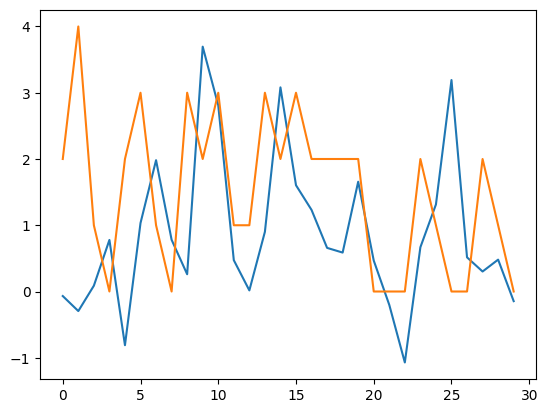

In [ ]:
i = 4
plt.plot(y_test_pred[i])
plt.plot(y_test[i])
plt.show()

Model Validation mae :  223.31415755408153
